In [32]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout
import matplotlib.dates as mdates

In [33]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD','LTC-USD', 'ADA-USD',
    'DOT-USD', 'LINK-USD','SOL-USD',
    'TRX-USD'
]

In [34]:
data_visual = {}
for crypto in cryptos:
    data_visual[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data_visual[crypto] = data_visual[crypto][~data_visual[crypto].index.duplicated(keep='first')]

In [35]:
data_visual['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value
Date,,
2019-05-11,0.121628,0.008682
2019-05-12,-0.032613,0.008262
2019-05-13,0.114250,0.011040
2019-05-14,0.023609,0.009788
2019-05-15,0.026652,0.009463
...,...,...
2024-10-16,0.008470,0.003743
2024-10-17,-0.003218,-0.000829
2024-10-18,0.014719,0.006106


0.008 representa o 5% maiores valores de exp_value preditos

In [36]:
for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()

    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()


    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] < 0)).sum()

    #rmse = np.sqrt(((df['Crypto_Return_Today'] - df['exp_value']) ** 2).mean())
    print("\n\n--------------------------------------------------------")
    print("\n\nCriptomoeda: ", crypto)
    print("\n                              Real")
    print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
    print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")

    print("\n                              Predito")
    print("\nNumero de Subidas: ",hat_pos,"   |   ", 100*hat_pos / (hat_neg + hat_pos),"%")
    print("\nNumero de Quedas : ",hat_neg,"   |   ", 100*hat_neg / (hat_neg + hat_pos),"%")

    print("\nMean Absolute Error MAE: ", df['ae'].mean())
    #print("\nRoot Mean Squared Error RMSE: ", rmse)
    print("\nAcc: ", (TP+TN) / (TP + FP + FN + FP))
    print("\nSen: ", (TP) / (TP + FN)) # significa, entre os que subiram, quantos % eu consegui identificar que realmente subiu
    print("\nSpe: ", (TP) / (TP + FN)) # significa, entre os que cairam, quantos % eu consegui identificar que realmente caiu
    print("\nPre: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram

    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0) & (df['exp_value'] >= 0.008)).sum()
    FP = (((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)) & (df['exp_value'] >= 0.008)).sum()

    limite_90 = df['exp_value'].quantile(0.9)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()
    print("\nLower bound dos 10% maiores: ", menor_valor_10_maiores)
    print("\nPrecisao para maiores que 0.008: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram



--------------------------------------------------------


Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  1014    |    50.95477386934673 %

Numero de Quedas :  976    |    49.04522613065327 %

                              Predito

Numero de Subidas:  1158    |    58.19095477386934 %

Numero de Quedas :  832    |    41.80904522613066 %

Mean Absolute Error MAE:  0.023693895352523132

Acc:  0.49053030303030304

Sen:  0.6005917159763313

Spe:  0.6005917159763313

Pre:  0.5259067357512953

Lower bound dos 10% maiores:  0.0089444918558001

Precisao para maiores que 0.008:  0.5725806451612904


--------------------------------------------------------


Criptomoeda:  ETH-USD

                              Real

Numero de Subidas:  1030    |    51.75879396984924 %

Numero de Quedas :  960    |    48.24120603015076 %

                              Predito

Numero de Subidas:  1155    |    58.040201005025125 %

Numero de Quedas :  835    |    41.959798994974875

---

Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  957    |    50.63492063492063 %

Numero de Quedas :  933    |    49.36507936507937 %

                              Predito

Numero de Subidas:  1063    |    56.24338624338624 %

Numero de Quedas :  827    |    43.75661375661376 %

Mean Absolute Error MAE:  0.022929531972738317

Acc:  0.49822425164890916

Sen:  0.58098223615465

Spe:  0.58098223615465

Pre:  0.5230479774223895

Lower bound dos 10% maiores:  0.0081897368654608

Precisao para maiores que 0.008:  0.5707070707070707


--------------------------------------------------------


Criptomoeda:  ETH-USD

                              Real

Numero de Subidas:  974    |    51.53439153439153 %

Numero de Quedas :  916    |    48.46560846560847 %

                              Predito

Numero de Subidas:  1081    |    57.195767195767196 %

Numero de Quedas :  809    |    42.804232804232804 %

Mean Absolute Error MAE:  0.02967418686373406

Acc:  0.4855

Sen:  0.5831622176591376

Spe:  0.5831622176591376

Pre:  0.5254394079555966

Lower bound dos 10% maiores:  0.0101016396656632

Precisao para maiores que 0.008:  0.5390070921985816


--------------------------------------------------------


Criptomoeda:  LTC-USD

                              Real

Numero de Subidas:  973    |    51.48148148148148 %

Numero de Quedas :  917    |    48.51851851851852 %

                              Predito

Numero de Subidas:  921    |    48.73015873015873 %

Numero de Quedas :  969    |    51.26984126984127 %

Mean Absolute Error MAE:  0.031932366817318245

Acc:  0.5121032813340506

Sen:  0.49126413155190135

Spe:  0.49126413155190135

Pre:  0.5190010857763301

Lower bound dos 10% maiores:  0.0085870809853076

Precisao para maiores que 0.008:  0.5260663507109005


--------------------------------------------------------


Criptomoeda:  ADA-USD

                              Real

Numero de Subidas:  958    |    50.714663843303335 %

Numero de Quedas :  931    |    49.285336156696665 %

                              Predito

Numero de Subidas:  904    |    47.83068783068783 %

Numero de Quedas :  986    |    52.16931216931217 %

Mean Absolute Error MAE:  0.03500963619803125

Acc:  0.53125

Sen:  0.49164926931106473

Spe:  0.49164926931106473

Pre:  0.5210176991150443

Lower bound dos 10% maiores:  0.0135052315890789

Precisao para maiores que 0.008:  0.5176151761517616


--------------------------------------------------------


Criptomoeda:  DOT-USD

                              Real

Numero de Subidas:  720    |    49.930651872399444 %

Numero de Quedas :  722    |    50.069348127600556 %

                              Predito

Numero de Subidas:  640    |    44.382801664355064 %

Numero de Quedas :  802    |    55.617198335644936 %

Mean Absolute Error MAE:  0.03690660648679021

Acc:  0.5583832335329342

Sen:  0.46111111111111114

Spe:  0.46111111111111114

Pre:  0.51875

Lower bound dos 10% maiores:  0.0124539732933044

Precisao para maiores que 0.008:  0.5


--------------------------------------------------------


Criptomoeda:  LINK-USD

                              Real

Numero de Subidas:  979    |    51.7989417989418 %

Numero de Quedas :  911    |    48.2010582010582 %

                              Predito

Numero de Subidas:  1012    |    53.544973544973544 %

Numero de Quedas :  878    |    46.455026455026456 %

Mean Absolute Error MAE:  0.039988347630485935

Acc:  0.46788062721294893

Sen:  0.5240040858018387

Spe:  0.5240040858018387

Pre:  0.5069169960474308

Lower bound dos 10% maiores:  0.0125243719667196

Precisao para maiores que 0.008:  0.486646884272997


--------------------------------------------------------


Criptomoeda:  SOL-USD

                              Real

Numero de Subidas:  789    |    50.12706480304956 %

Numero de Quedas :  785    |    49.87293519695044 %

                              Predito

Numero de Subidas:  890    |    56.5438373570521 %

Numero de Quedas :  684    |    43.4561626429479 %

Mean Absolute Error MAE:  0.047768711905629126

Acc:  0.5033557046979866

Sen:  0.5893536121673004

Spe:  0.5893536121673004

Pre:  0.5224719101123596

Lower bound dos 10% maiores:  0.0218559987843036

Precisao para maiores que 0.008:  0.530241935483871


--------------------------------------------------------


Criptomoeda:  TRX-USD

                              Real

Numero de Subidas:  1020    |    53.99682371625199 %

Numero de Quedas :  869    |    46.00317628374801 %

                              Predito

Numero de Subidas:  1109    |    58.67724867724868 %

Numero de Quedas :  781    |    41.32275132275132 %

Mean Absolute Error MAE:  0.027583704712704767

Acc:  0.4807312252964427

Sen:  0.5941176470588235

Spe:  0.5941176470588235

Pre:  0.5469314079422383

Lower bound dos 10% maiores:  0.007676844485104

Precisao para maiores que 0.008:  0.5058139534883721

In [37]:
df = data_visual['ETH-USD']
df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
df['ae'] = abs(df['ae'])

In [38]:
df['mae'] = df['ae'].rolling(window = 60).mean()

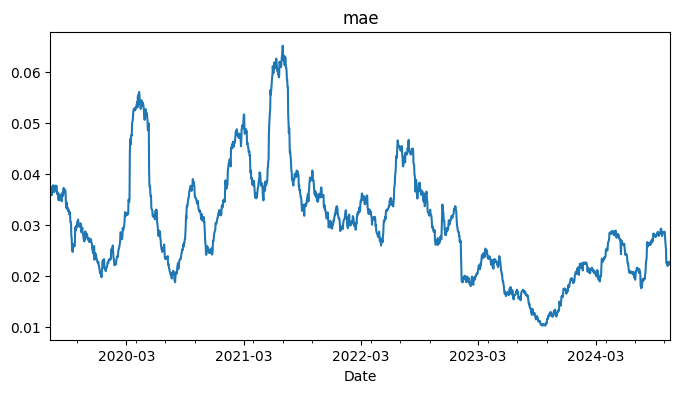

In [39]:
from matplotlib import pyplot as plt
df.index = pd.to_datetime(df.index)
df['mae'].dropna(how = 'all').plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # Exibe uma data por mês
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Exibe no formato Ano-Mês

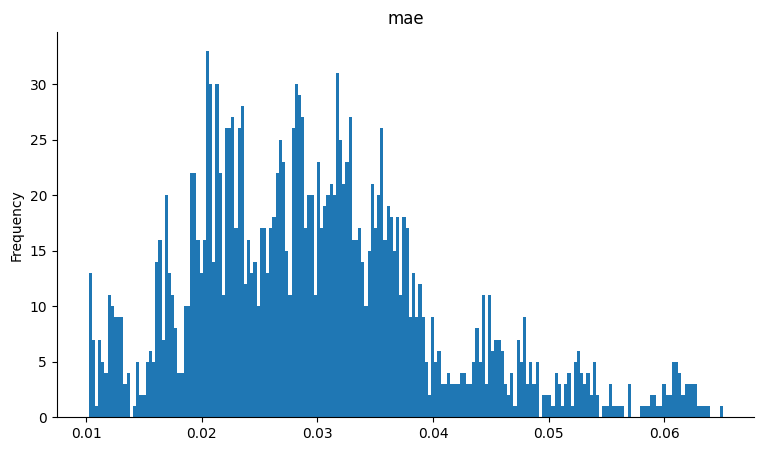

In [40]:
from matplotlib import pyplot as plt
df['mae'].plot(kind='hist', figsize=(9, 5), bins=200, title='mae')
plt.gca().spines[['top', 'right',]].set_visible(False)

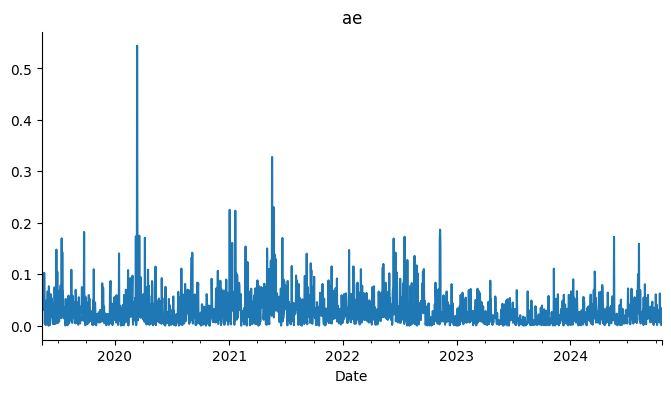

In [41]:
from matplotlib import pyplot as plt
df['ae'].dropna(how = 'all').plot(kind='line', figsize=(8, 4), title='ae')
plt.gca().spines[['top', 'right']].set_visible(False)

### **Vamos criar data2**
#### Este será um dicionário que lê os csv's salvos e os armazena para cada criptomoeda

In [42]:
data2 = {}
for crypto in cryptos:
    data2[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data2[crypto] = data2[crypto][~data2[crypto].index.duplicated(keep='first')]
    #data_complete[crypto] = pd.read_csv(f"{crypto}.csv")

In [43]:
for crypto in cryptos:
    print(len(data2[crypto]))
    data2[crypto] = data2[crypto]


2983
2538
2983
2538
1523
2538
1655
2538


In [44]:
data2['BTC-USD']

,Crypto_Return_Today,exp_value
Date,,
2016-08-21,-0.001085,NaN
2016-08-22,0.009318,NaN
2016-08-23,-0.005736,NaN
2016-08-24,-0.005552,NaN
2016-08-25,-0.004178,NaN
...,...,...
2024-10-16,0.008470,0.003743
2024-10-17,-0.003218,-0.000829
2024-10-18,0.014719,0.006106


### **Vamos criar data_mus**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor esperado de um dos ativos de nosso portifólio.

In [45]:
data_mus = pd.DataFrame()
for crypto in cryptos:
    data_mus = pd.merge(data_mus, data2[crypto]['exp_value'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))
    data_mus = data_mus.rename(columns={f'exp_value{crypto}': crypto})

In [46]:
#data_mus.fillna(0, inplace=True)
data_mus = data_mus.rename(columns={'exp_value': 'BTC-USD'})
data_mus.dropna(how = 'all')

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2019-05-11,0.008682,0.001932,0.003730,0.003504,NaN,0.008152,NaN,-0.005215
2019-05-12,0.008262,0.006155,-0.014341,0.003639,NaN,-0.000331,NaN,-0.006394
2019-05-13,0.011040,0.004553,0.006549,-0.001371,NaN,0.012743,NaN,0.001475
2019-05-14,0.009788,0.007870,0.001682,0.006464,NaN,0.006653,NaN,-0.001198
2019-05-15,0.009463,0.027431,0.005694,0.052922,NaN,0.023321,NaN,0.000519
...,...,...,...,...,...,...,...,...
2024-10-16,0.003743,0.009319,0.009478,0.000991,0.002552,0.002543,0.005475,0.004135
2024-10-17,-0.000829,0.001030,-0.003648,0.000392,0.000020,-0.000362,0.002275,0.001567
2024-10-18,0.006106,0.000691,0.003061,0.002838,0.004308,0.003416,0.000949,0.001356


### **Vamos criar data_reals**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor real de um dos ativos de nosso portifólio.

In [47]:
data_reals = pd.DataFrame()
for crypto in cryptos:
    data_reals = pd.merge(data_reals, data2[crypto]['Crypto_Return_Today'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))
    data_reals = data_reals.rename(columns={f'Crypto_Return_Today{crypto}': crypto})

In [48]:
data_reals = data_reals.rename(columns={'Crypto_Return_Today': 'BTC-USD'})
data_reals

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2016-08-21,-0.001085,NaN,-0.001200,NaN,NaN,NaN,NaN,NaN
2016-08-22,0.009318,NaN,0.010953,NaN,NaN,NaN,NaN,NaN
2016-08-23,-0.005736,NaN,0.070155,NaN,NaN,NaN,NaN,NaN
2016-08-24,-0.005552,NaN,-0.018953,NaN,NaN,NaN,NaN,NaN
2016-08-25,-0.004178,NaN,-0.014212,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-16,0.008470,0.001948,-0.011386,-0.016882,-0.019825,-0.017466,-0.003149,0.007900
2024-10-17,-0.003218,-0.002653,0.037386,-0.027303,-0.030039,-0.019495,-0.025758,-0.004309
2024-10-18,0.014719,0.014005,0.005285,0.022151,0.027627,0.040463,0.030485,-0.005173


### **Vamos criar  mus e reals e covs**
#### mus será um dicionário, cujas chaves são as datas que compõe o index de data_mus, e cada item é um numpy array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
#### reals será um dicionário cujas chaves são as datas que compõe do index de data_mus, e cada item é um np array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
##### *Importante!* - Vamos fazer de tal modo que, para os arrays com valores NaN, nós removemos ele do portifólio

In [49]:
covs = {}
mus = {}
reals = {}

for i in range(100, data_mus.shape[0], 1):
    if(i < 200):
        df1 = data_reals[0:i] # Tabela que vai me ajudar a criar a matriz de covariância
        df2 = data_mus[i:i+1] # de onde vou coletar o previsto
        df3 = data_reals[i:i+1] # de onde vou coletar o real
    else:
        df1 = data_reals[i-200:i] # Tabela que vai me ajudar a criar a matriz de covariância
        df2 = data_mus[i:i+1]
        df3 = data_reals[i:i+1] # de onde vou coletar o real
        
    cols_with_nan_in_df2 = df2.isna().any()
    # Remover do df1 as colunas que possuem NaN em df2
    df1_cleaned = df1.drop(columns=df1.columns[cols_with_nan_in_df2])
    df2_cleaned = df2.dropna(axis=1)
    df3_cleaned = df3.drop(columns=df1.columns[cols_with_nan_in_df2])
    # Remover do df2 as colunas que possuem 60% NaN em df1
    percent_nan_df1 = df1_cleaned.isna().mean()
    cols_to_drop = percent_nan_df1[percent_nan_df1 >= 0.6].index
    df1_cleaned = df1_cleaned.drop(columns=cols_to_drop, errors='ignore')
    df2_cleaned = df2_cleaned.drop(columns=cols_to_drop, errors='ignore')
    df3_cleaned = df3_cleaned.drop(columns=cols_to_drop, errors='ignore')

    date = data_mus.index[i]
    covs[date] = df1_cleaned.cov()
    mus[date] = df2_cleaned
    reals[date] = df3_cleaned


covs[date]
mus[date]
reals[date]


São todos dataframes

pra retirar o valor de mus e reals basta fazer um .to_numpy().flatten()

In [50]:
"""covs = {}
for i in range(100, data_mus.shape[0], 1):
    df = pd.DataFrame()
    if(i < 200):
        df = data_reals_with_RFR.iloc[0: i].dropna(axis = 1)
    else:
        df = data_reals_with_RFR.iloc[i-200: i].dropna(axis = 1)
    date = data_reals_with_RFR.index[i]

    covs[date] = df.cov().to_numpy()"""

'covs = {}\nfor i in range(100, data_mus.shape[0], 1):\n    df = pd.DataFrame()\n    if(i < 200):\n        df = data_reals_with_RFR.iloc[0: i].dropna(axis = 1)\n    else:\n        df = data_reals_with_RFR.iloc[i-200: i].dropna(axis = 1)\n    date = data_reals_with_RFR.index[i]\n\n    covs[date] = df.cov().to_numpy()'

In [51]:
"""reals = {}
mus = {}

for i in range(100, data_mus.shape[0], 1):
    date = data_reals_with_RFR.index[i]
    
    for crypto in cryptos:
        if date in data2[crypto].index:
            if data2[crypto].
            reals[date] = np.append(reals[date], 1)"""

'reals = {}\nmus = {}\n\nfor i in range(100, data_mus.shape[0], 1):\n    date = data_reals_with_RFR.index[i]\n    \n    for crypto in cryptos:\n        if date in data2[crypto].index:\n            if data2[crypto].\n            reals[date] = np.append(reals[date], 1)'

In [52]:
"""reals = {}
mus = {} # mus[date] será um numpy array de K elementos
for i in range(data_mus.shape[0]):
    date = data_mus.index[i]

    mus[date] = data_mus.iloc[i].to_numpy()
    reals[date] = data_reals.iloc[i].to_numpy()

    
    reals[date] = reals[date][~np.isnan(mus[date])]
    mus[date] = mus[date][~np.isnan(mus[date])]

    mus[date] = np.exp(mus[date]) - 1
    reals[date] = np.exp(reals[date]) - 1

    reals[date] = np.append(reals[date], 0.00031)
    mus[date] = np.append(mus[date], 0.00031)"""

'reals = {}\nmus = {} # mus[date] será um numpy array de K elementos\nfor i in range(data_mus.shape[0]):\n    date = data_mus.index[i]\n\n    mus[date] = data_mus.iloc[i].to_numpy()\n    reals[date] = data_reals.iloc[i].to_numpy()\n\n    \n    reals[date] = reals[date][~np.isnan(mus[date])]\n    mus[date] = mus[date][~np.isnan(mus[date])]\n\n    mus[date] = np.exp(mus[date]) - 1\n    reals[date] = np.exp(reals[date]) - 1\n\n    reals[date] = np.append(reals[date], 0.00031)\n    mus[date] = np.append(mus[date], 0.00031)'

In [53]:
"""reals = {} # mus[date] será um numpy array de 8 elementos
for i in range(data_reals.shape[0]):
    date = data_reals.index[i]
    reals[date] = data_reals.iloc[i].to_numpy()
    reals[date] = reals[date][~np.isnan(reals[date])]
    reals[date] = np.append(reals[date], 0.002)"""

'reals = {} # mus[date] será um numpy array de 8 elementos\nfor i in range(data_reals.shape[0]):\n    date = data_reals.index[i]\n    reals[date] = data_reals.iloc[i].to_numpy()\n    reals[date] = reals[date][~np.isnan(reals[date])]\n    reals[date] = np.append(reals[date], 0.002)'

em cada dia: date

covs[date] é a matriz de covariancia


mus[date] é o vetor de valores preditos


reals[date] é o vetor de valores reais


isso gera um portifólio ws[date]


para esse portifólio, vamos ter como retorno percentual ws[date]*(e^mus[date] - 1) que vamos armazenar em profit[date]

In [54]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=len(mu), n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        if exp_risk <= 0.00001:
            sharpe = 0
        else:
            sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]


from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [55]:
import os
def Portfolio(mu, cov, day):
    # Solução com GA
    problem = PortfolioProblemGA(mu, cov)


    algorithm = GA(
        pop_size=100,
        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()), # Simulated Binary Crossover, hyperparameters: prob of crossover, eta - parameter of crossover distribution
        mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()),  
        eliminate_duplicates=True)

    res = minimize(problem, # observe que estamos minimizando
                algorithm,
                termination=('n_gen', 1000),# Criterio de termino: numero de geracoes!
                seed=1,
                verbose=False)
    
    # Apresentação dos Resultados
    #res.X: Design space values are
    #res.F: Objective spaces values

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.savefig(os.path.join(save_directory, f'portfolio_plot_{day}.png'), bbox_inches='tight')
    plt.close()  # Fecha a figura para liberar memória
    import operator

    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()
    
    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    pesos = []
    for name, w in allocation.items():
        pesos = np.append(pesos, w)
    return pesos


In [56]:
# Define o caminho para salvar as imagens
global save_directory 
save_directory = "C:\\Users\\delve\OneDrive\\Eu\\GitHub\\Quantamental\\Código\\Plots"  # Altere para o caminho desejado
os.makedirs(save_directory, exist_ok=True)  # Cria a pasta se não existir


### Pesos sera um dicionário que vai armazenar os pesos que devo distribuir nas ações na determinada data: date

In [57]:
pesos = {}

In [58]:
date = data_mus.index[1900]
date

'2021-11-03'

In [59]:
date = data_mus.index[1093]
date

'2019-08-19'

In [60]:

date = '2019-08-23'
covs[date]

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,LINK-USD,TRX-USD
BTC-USD,0.001611,0.001489,0.001508,0.001403,0.001069,0.001291
ETH-USD,0.001489,0.002006,0.001939,0.001864,0.001516,0.001643
LTC-USD,0.001508,0.001939,0.002902,0.002166,0.001456,0.001758
ADA-USD,0.001403,0.001864,0.002166,0.002636,0.001381,0.001925
LINK-USD,0.001069,0.001516,0.001456,0.001381,0.005375,0.001418
TRX-USD,0.001291,0.001643,0.001758,0.001925,0.001418,0.002363


In [61]:
data_mus.dropna(how = 'all')

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2019-05-11,0.008682,0.001932,0.003730,0.003504,NaN,0.008152,NaN,-0.005215
2019-05-12,0.008262,0.006155,-0.014341,0.003639,NaN,-0.000331,NaN,-0.006394
2019-05-13,0.011040,0.004553,0.006549,-0.001371,NaN,0.012743,NaN,0.001475
2019-05-14,0.009788,0.007870,0.001682,0.006464,NaN,0.006653,NaN,-0.001198
2019-05-15,0.009463,0.027431,0.005694,0.052922,NaN,0.023321,NaN,0.000519
...,...,...,...,...,...,...,...,...
2024-10-16,0.003743,0.009319,0.009478,0.000991,0.002552,0.002543,0.005475,0.004135
2024-10-17,-0.000829,0.001030,-0.003648,0.000392,0.000020,-0.000362,0.002275,0.001567
2024-10-18,0.006106,0.000691,0.003061,0.002838,0.004308,0.003416,0.000949,0.001356


In [68]:
date = data_mus.index[993]
date

'2019-05-11'

In [69]:
for i in range(993,1500, 1):
    date = data_mus.index[i]
    pesos[date] = Portfolio(mus[date].to_numpy().flatten(), covs[date].to_numpy(), i)
    print("Etapa ", i, " de ", 2241)

Etapa  993  de  2241
Etapa  994  de  2241
Etapa  995  de  2241
Etapa  996  de  2241
Etapa  997  de  2241
Etapa  998  de  2241
Etapa  999  de  2241
Etapa  1000  de  2241
Etapa  1001  de  2241
Etapa  1002  de  2241
Etapa  1003  de  2241
Etapa  1004  de  2241
Etapa  1005  de  2241
Etapa  1006  de  2241
Etapa  1007  de  2241
Etapa  1008  de  2241
Etapa  1009  de  2241
Etapa  1010  de  2241
Etapa  1011  de  2241
Etapa  1012  de  2241
Etapa  1013  de  2241
Etapa  1014  de  2241
Etapa  1015  de  2241
Etapa  1016  de  2241
Etapa  1017  de  2241
Etapa  1018  de  2241
Etapa  1019  de  2241
Etapa  1020  de  2241
Etapa  1021  de  2241
Etapa  1022  de  2241
Etapa  1023  de  2241
Etapa  1024  de  2241
Etapa  1025  de  2241
Etapa  1026  de  2241
Etapa  1027  de  2241
Etapa  1028  de  2241
Etapa  1029  de  2241
Etapa  1030  de  2241
Etapa  1031  de  2241
Etapa  1032  de  2241
Etapa  1033  de  2241
Etapa  1034  de  2241
Etapa  1035  de  2241
Etapa  1036  de  2241
Etapa  1037  de  2241
Etapa  1038  de  

In [74]:
for elem in pesos:
    print(len(pesos[elem]), reals[elem].shape[1])

8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8


In [ ]:
for elem in pesos:
    if len(pesos[elem]) == 7:
        pesos[elem] = np.append(pesos[elem], 0)
    if reals[elem].shape[1] == 7:
        reals[elem]['lixo2'] = 0
    if mus[elem].shape[1] == 7:
        mus[elem]['lixo2'] = 0

    if len(pesos[elem]) == 6:
        pesos[elem] = np.append(pesos[elem], 0)
    if reals[elem].shape[1] == 6:
        reals[elem]['lixo1'] = 0
    if mus[elem].shape[1] == 6:
        mus[elem]['lixo1'] = 0

In [87]:
for elem in mus:
    if mus[elem].shape[1] == 6:
        mus[elem]['lixo1'] = 0
    if reals[elem].shape[1] == 6:
        reals[elem]['lixo1'] = 0

    if reals[elem].shape[1] == 7:
        reals[elem]['lixo2'] = 0
    if mus[elem].shape[1] == 7:
        mus[elem]['lixo2'] = 0

In [88]:
pd.DataFrame(pesos).T.sort_index()

,0,1,2,3,4,5,6,7
2019-05-11,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2019-05-12,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2019-05-13,0.959367,0.0,0.000000,0.0,0.040633,0.000000,0.000000,0.0
2019-05-14,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2019-05-15,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...
2020-09-24,0.000000,0.0,0.000000,0.0,0.000000,0.931958,0.068042,0.0
2020-09-25,0.000000,0.0,0.000000,0.0,0.000000,0.481706,0.518294,0.0
2020-09-26,0.000000,0.0,0.396858,0.0,0.000000,0.554609,0.048534,0.0
2020-09-27,0.000000,0.0,0.000000,0.0,0.882602,0.117398,0.000000,0.0


In [77]:
data_aux = pd.read_csv('pesos1.csv', index_col = 0,  parse_dates=True)
data_aux.index = pd.to_datetime(data_aux.index)
data_aux

,0,1,2,3,4,5,6,7
2020-09-29,0.0,0.00000,0.000000,0.0,0.43617,0.0,0.563830,0.000000
2020-09-30,0.0,0.00000,0.000000,0.0,0.00000,0.0,1.000000,0.000000
2020-10-01,0.0,0.00000,0.000000,0.0,0.00000,1.0,0.000000,0.000000
2020-10-02,0.0,0.85490,0.000000,0.0,0.14510,0.0,0.000000,0.000000
2020-10-03,0.0,0.00000,0.124668,0.0,0.00000,0.0,0.875332,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.0,0.41676,0.583240,0.0,0.00000,0.0,0.000000,0.000000
2024-10-17,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.287129,0.712871
2024-10-18,1.0,0.00000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
2024-10-19,1.0,0.00000,0.000000,0.0,0.00000,0.0,0.000000,0.000000


In [78]:
data_aux.columns = pd.DataFrame(pesos).T.sort_index().columns
data_aux


,0,1,2,3,4,5,6,7
2020-09-29,0.0,0.00000,0.000000,0.0,0.43617,0.0,0.563830,0.000000
2020-09-30,0.0,0.00000,0.000000,0.0,0.00000,0.0,1.000000,0.000000
2020-10-01,0.0,0.00000,0.000000,0.0,0.00000,1.0,0.000000,0.000000
2020-10-02,0.0,0.85490,0.000000,0.0,0.14510,0.0,0.000000,0.000000
2020-10-03,0.0,0.00000,0.124668,0.0,0.00000,0.0,0.875332,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.0,0.41676,0.583240,0.0,0.00000,0.0,0.000000,0.000000
2024-10-17,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.287129,0.712871
2024-10-18,1.0,0.00000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
2024-10-19,1.0,0.00000,0.000000,0.0,0.00000,0.0,0.000000,0.000000


In [79]:
pesos_concat = pd.concat([pd.DataFrame(pesos).T.sort_index(), data_aux])
pesos_concat.index = pd.to_datetime(pesos_concat.index)
pesos_concat

,0,1,2,3,4,5,6,7
2019-05-11,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2019-05-12,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2019-05-13,0.959367,0.00000,0.00000,0.0,0.040633,0.0,0.000000,0.000000
2019-05-14,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2019-05-15,0.000000,0.00000,0.00000,1.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.000000,0.41676,0.58324,0.0,0.000000,0.0,0.000000,0.000000
2024-10-17,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.287129,0.712871
2024-10-18,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2024-10-19,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000


In [80]:
pd.DataFrame(pesos_concat).sort_index().to_csv('pesos1.csv', index=True)

In [89]:
df = pd.read_csv('pesos1.csv', index_col = 0,  parse_dates=True)
df

,0,1,2,3,4,5,6,7
2019-05-11,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2019-05-12,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2019-05-13,0.959367,0.00000,0.00000,0.0,0.040633,0.0,0.000000,0.000000
2019-05-14,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2019-05-15,0.000000,0.00000,0.00000,1.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.000000,0.41676,0.58324,0.0,0.000000,0.0,0.000000,0.000000
2024-10-17,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.287129,0.712871
2024-10-18,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000
2024-10-19,1.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,0.000000


In [117]:
profit = {}
for i in range(200, df.shape[0]):
    date = df.index[i].strftime('%Y-%m-%d')
    w = df.loc[date].to_numpy()
    r = np.exp(reals[date].to_numpy().flatten())
    if df.iloc[i].sum() == 1 and w @ mus[date].to_numpy().flatten() > 0.005 :
        profit[date] = w @ r
    else:
        profit[date] = 1.0002

In [118]:
df_profit = pd.DataFrame([profit], index=[0]).T
df_profit

,0
2019-11-27,1.000200
2019-11-28,1.000200
2019-11-29,1.000200
2019-11-30,0.976072
2019-12-01,1.000200
...,...
2024-10-16,0.994209
2024-10-17,1.000200
2024-10-18,1.014828
2024-10-19,0.999178


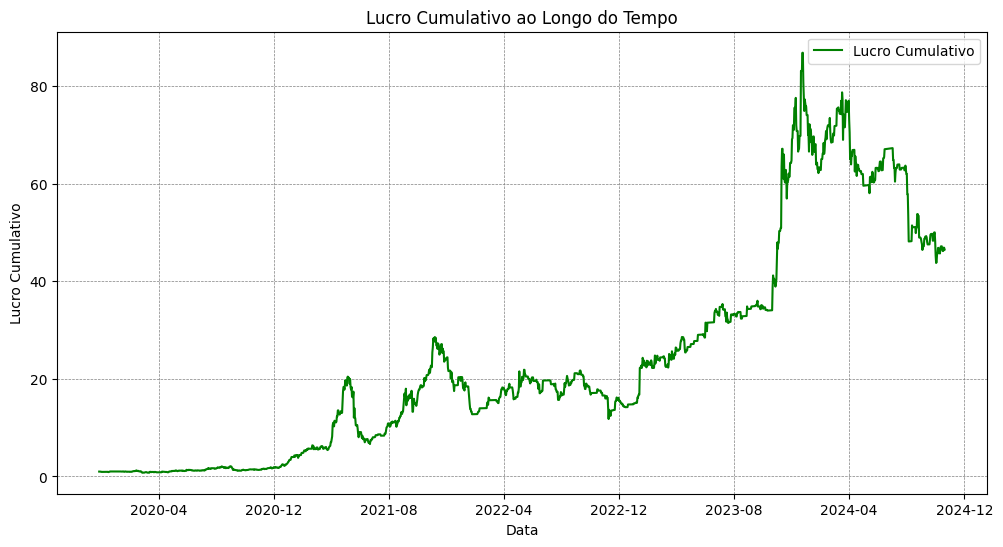

In [121]:

df_profit.index = pd.to_datetime(df_profit.index)
# Calcula o produto cumulativo dos valores na coluna de lucro
df_profit['cumulative_profit'] = df_profit[0].cumprod()

# Define o tamanho do gráfico (opcional)
plt.figure(figsize=(12, 6))

# Plota a série temporal do lucro cumulativo
plt.plot(df_profit.index, df_profit['cumulative_profit'], label="Lucro Cumulativo", color='green')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8))  # Exibe uma data por mês
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Exibe no formato Ano-Mês
# Personaliza o gráfico
plt.title("Lucro Cumulativo ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Lucro Cumulativo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # `which='both'` adiciona a grade principal 
plt.savefig("lucro_cumulativo_ajustado_2019-01-01_com_restricao.png", format="png", dpi=300, bbox_inches="tight")  # Salva em alta resolução com bordas ajustadas
# Exibe o gráfico
plt.show()



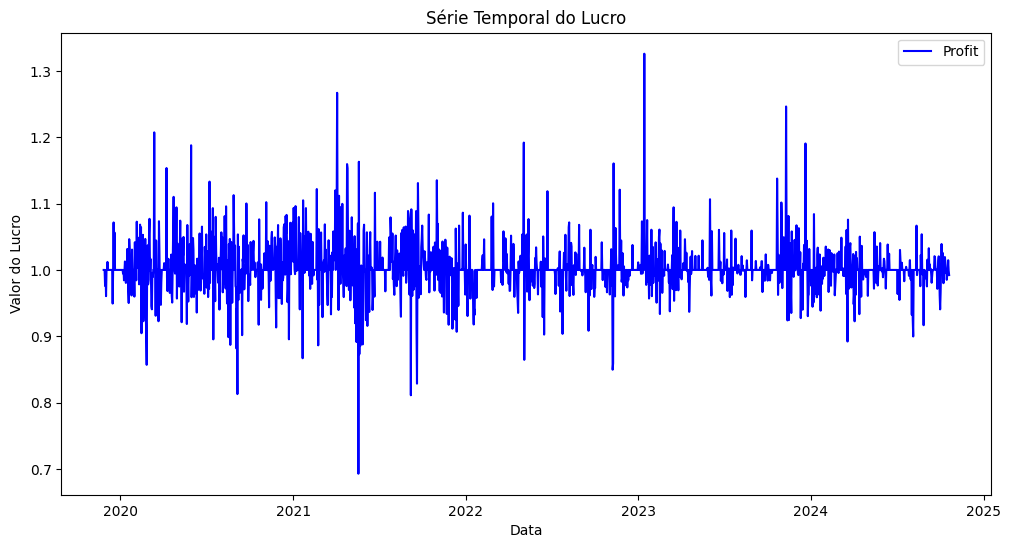

In [122]:
# Define o tamanho do gráfico (opcional)
plt.figure(figsize=(12, 6))

# Plota a série temporal
plt.plot(df_profit.index, df_profit[0], label="Profit", color='blue')

# Personaliza o gráfico
plt.title("Série Temporal do Lucro")
plt.xlabel("Data")
plt.ylabel("Valor do Lucro")
plt.legend()
plt.savefig("lucro_serie_temporal.png", format="png", dpi=300, bbox_inches="tight")  # Salva em alta resolução com bordas ajustadas
# Exibe o gráfico
plt.show()

In [115]:
df_profit = df_profit.rename(columns={0: "profit"})

In [116]:
df_profit.describe()

,profit,cumulative_profit
count,1790.000000,1790.000000
mean,1.002732,17.630413
std,0.035062,16.760435
min,0.693111,0.731549
25%,1.000200,3.057706
50%,1.000200,12.069507
75%,1.000200,26.340862
max,1.326012,61.945694


In [99]:
df_profit.to_csv("df_profit_1.csv")